In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
data = pd.read_csv("../NullValueHandled/jaffnaHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000058
2019-01-02,2019-01-03,0.000102
2019-01-03,2019-01-04,0.000039
2019-01-04,2019-01-05,-0.000002
2019-01-05,2019-01-06,0.000159


In [6]:
jaffna_data = data[["HCHO reading"]]
jaffna_data.head()  

,HCHO reading
Current Date,
2019-01-01,0.000058
2019-01-02,0.000102
2019-01-03,0.000039
2019-01-04,-0.000002
2019-01-05,0.000159


In [269]:
jaffna_data.shape 

(1826, 1)

In [270]:
X = jaffna_data.values 

#### This looks like that Jaffna fomaldihyde rates have a small seasonality

<Axes: xlabel='Current Date'>

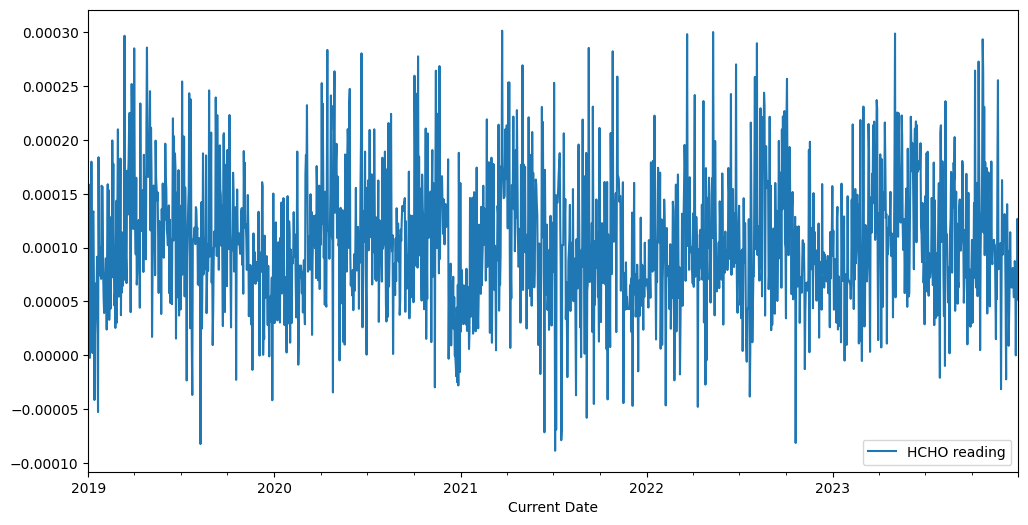

In [271]:
jaffna_data.plot(figsize=(12, 6)) 

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
test_jaffna = adfuller(jaffna_data["HCHO reading"], autolag="AIC") 

In [18]:
print("ADF value : ", test_jaffna[0])
print("P value: ", test_jaffna[1])
print("Num of Lags :", test_jaffna[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_jaffna[3])
for key, val in test_jaffna[4].items():
    print("\t", key, ": ", val)

ADF value :  -7.500971660167281
P value:  4.254622130663339e-11
Num of Lags : 11
Num of Observations used for ADF Regression and Critical Calculation : 1814
	 1% :  -3.4339600207952796
	 5% :  -2.863134623063046
	 10% :  -2.5676189242070433


#### Auto correlation and correlation plot for Jaffna

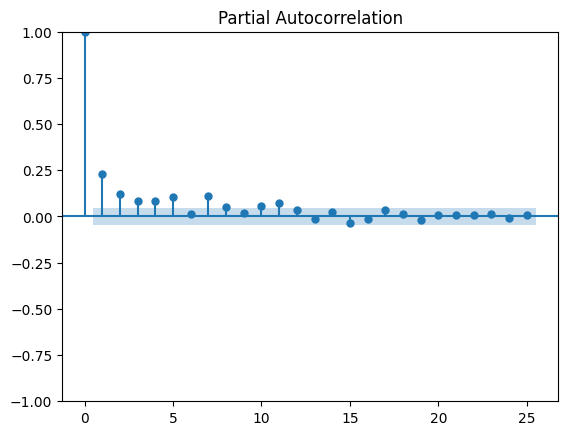

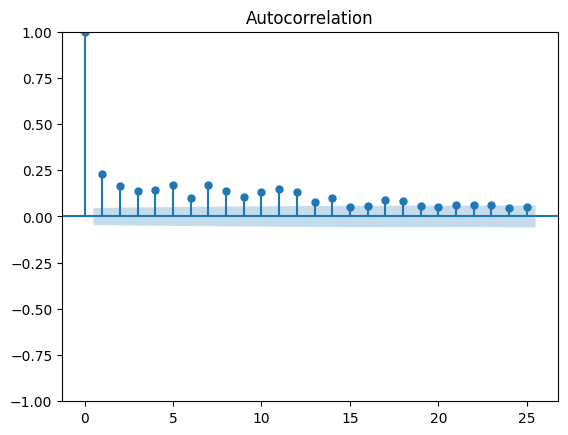

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(jaffna_data["HCHO reading"], lags=25)
acf = plot_acf(jaffna_data["HCHO reading"], lags=25)  

#### There is a small stationarity and seasonality in Jaffna data

#### Jaffna LSTM

In [37]:
data = pd.read_csv("../NullValueHandled/jaffnaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [38]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000058
1   2019-01-02      0.000102
2   2019-01-03      0.000039
3   2019-01-04     -0.000002
4   2019-01-05      0.000159


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 102s 1s/step - loss: 1.0603 - mean_squared_error: 1.0603 - val_loss: 0.9062 - val_mean_squared_error: 0.9062
Epoch 2/100
37/37 [==============================] - 26s 714ms/step - loss: 1.0055 - mean_squared_error: 1.0055 - val_loss: 0.9252 - val_mean_squared_error: 0.9252
Epoch 3/100
37/37 [==============================] - 15s 413ms/step - loss: 0.9956 - mean_squared_error: 0.9956 - val_loss: 1.0247 - val_mean_squared_error: 1.0247
Epoch 4/100
37/37 [==============================] - 15s 402ms/step - loss: 0.9744 - mean_squared_error: 0.9744 - val_loss: 0.9128 - val_mean_squared_error: 0.9128
Epoch 5/100
37/37 [==============================] - 14s 382ms/step - loss: 0.9726 - mean_squared_error: 0.9726 - val_loss: 1.0043 - val_mean_squared_error: 1.0043
Epoch 6/100
37/37 [==============================] - 14s 380ms/step - loss: 0.9611 - mean_squared_error: 0.9611 - val_loss: 0.8954 - val_mean_squared_error: 0.8954
Epoch 7/100
37/37 

Epoch 51/100
37/37 [==============================] - 17s 459ms/step - loss: 0.8252 - mean_squared_error: 0.8252 - val_loss: 1.0387 - val_mean_squared_error: 1.0387
Epoch 52/100
37/37 [==============================] - 18s 496ms/step - loss: 0.8112 - mean_squared_error: 0.8112 - val_loss: 1.1926 - val_mean_squared_error: 1.1926
Epoch 53/100
37/37 [==============================] - 16s 436ms/step - loss: 0.8610 - mean_squared_error: 0.8610 - val_loss: 0.9164 - val_mean_squared_error: 0.9164
Epoch 54/100
37/37 [==============================] - 15s 417ms/step - loss: 0.8026 - mean_squared_error: 0.8026 - val_loss: 0.9499 - val_mean_squared_error: 0.9499
Epoch 55/100
37/37 [==============================] - 14s 371ms/step - loss: 0.8171 - mean_squared_error: 0.8171 - val_loss: 0.9982 - val_mean_squared_error: 0.9982
Epoch 56/100
37/37 [==============================] - 13s 355ms/step - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.9740 - val_mean_squared_error: 0.9740
Epoch 57/1

12/12 [==============================] - 15s 107ms/step


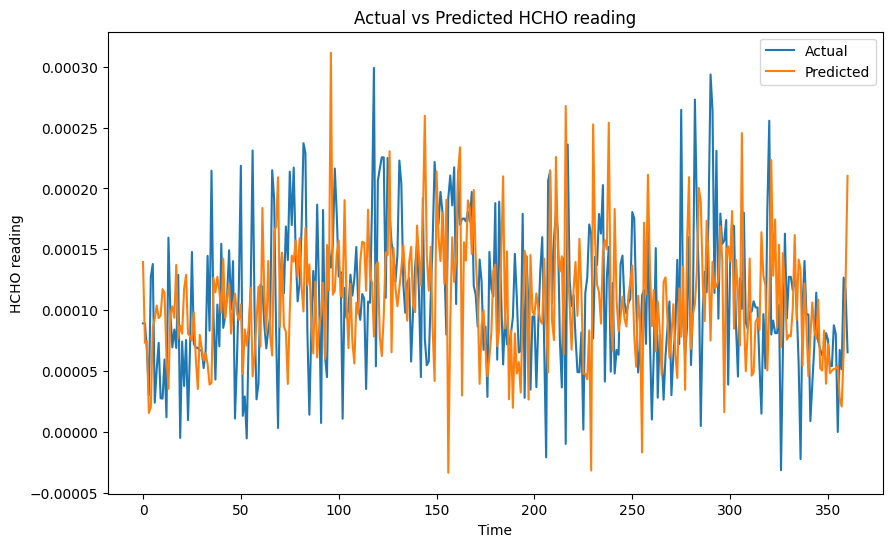

In [40]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 123ms/step


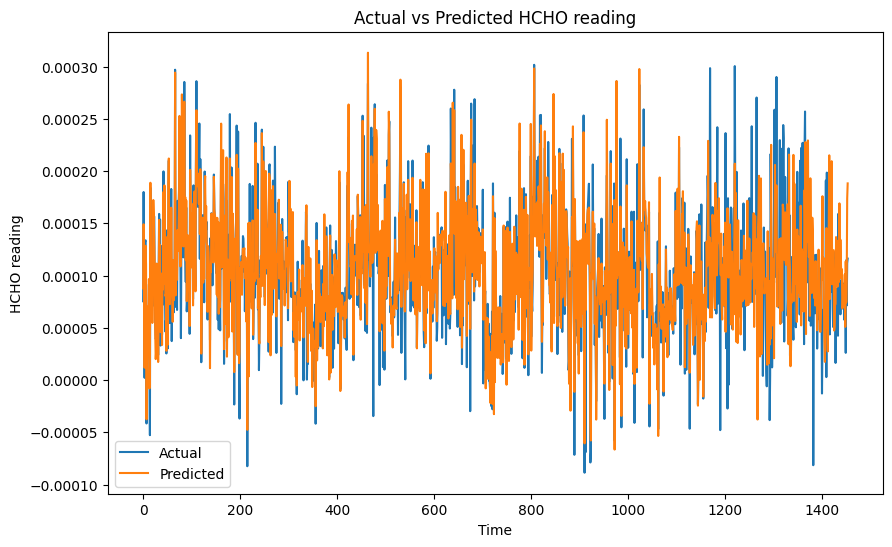

In [41]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 5s 98ms/step


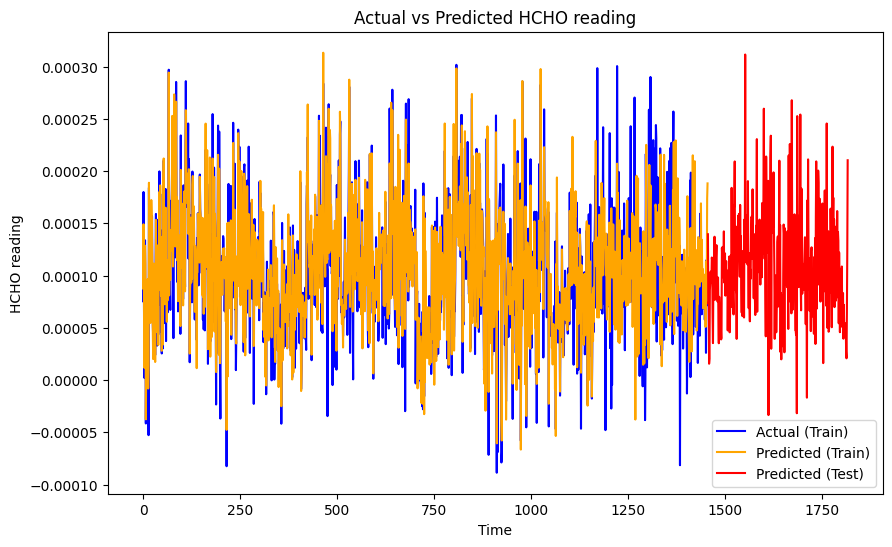

In [42]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [43]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6245367469069611
Mean Absolute Error (MAE): 2.356567771214922e-05
Mean Squared Error (MSE): 1.3467486626867525e-09
Root Mean Squared Error (RMSE): 3.6698074373006993e-05
Median Absolute Error: 1.5085225960387793e-05
Explained Variance Score: 0.625571765968431


09:37:24 - cmdstanpy - INFO - Chain [1] start processing
09:37:24 - cmdstanpy - INFO - Chain [1] done processing


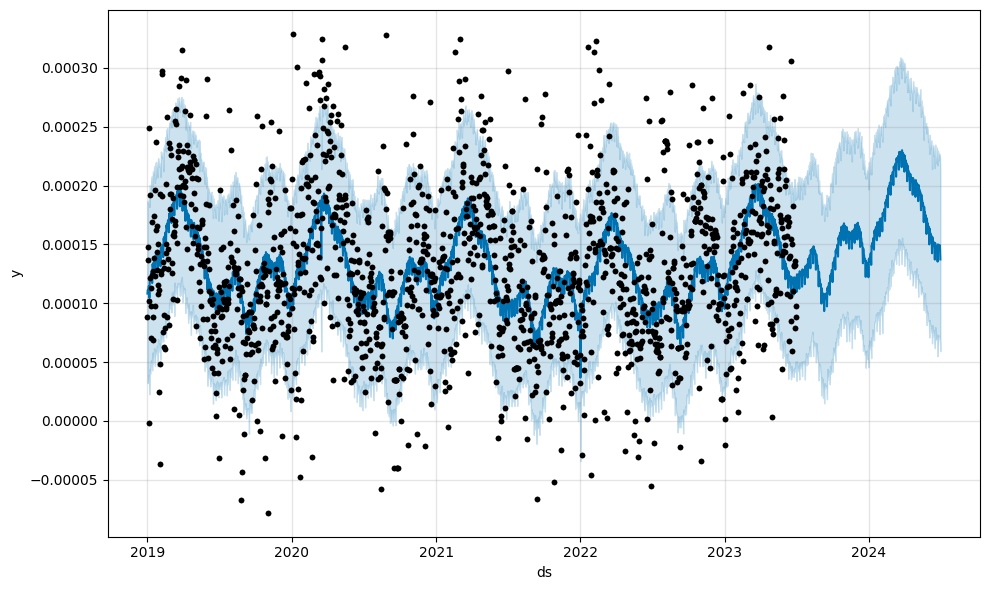

In [45]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/KurunegalaProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,
               changepoint_prior_scale=0.2, 
               seasonality_prior_scale=5,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

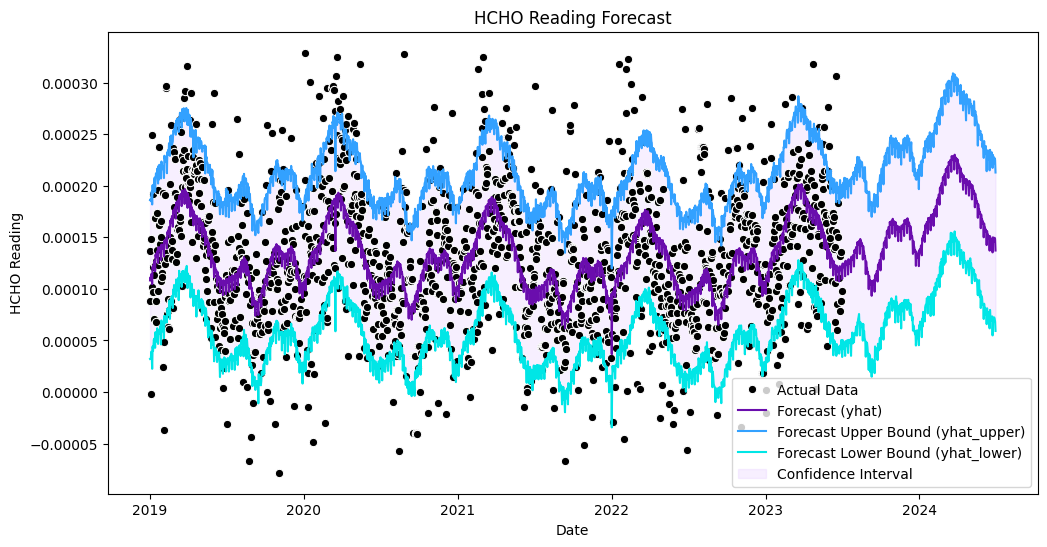

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

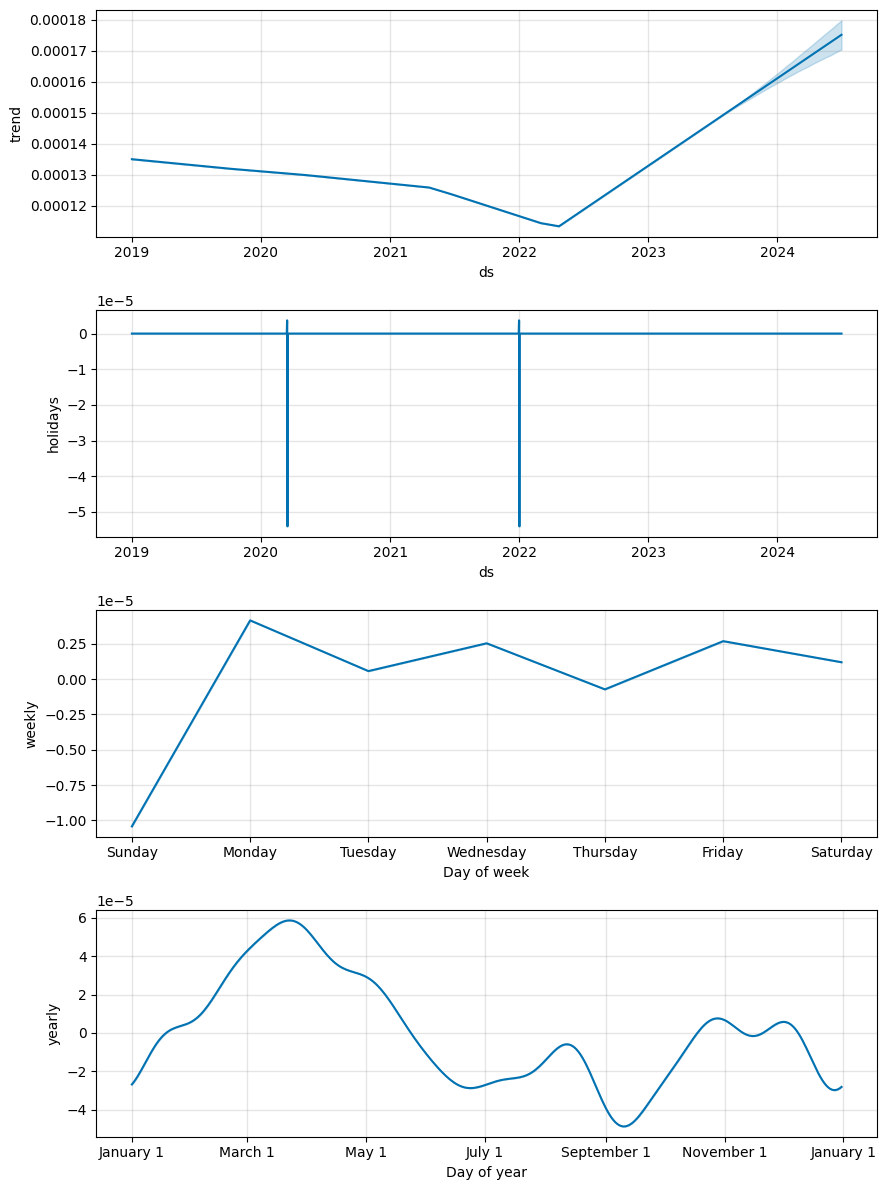

In [47]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [48]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.24090460356226395
Mean Absolute Error (MAE): 5.1367706162723475e-05
Mean Squared Error (MSE): 4.20306978271274e-09
Root Mean Squared Error (RMSE): 6.483108654582877e-05
Median Absolute Error: 4.6628677122368715e-05
Explained Variance Score: 0.07082367879966855


#### Jaffna Multi Variate Model

In [7]:
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   int64  
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [9]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,Jaffna Proper,9.66,80.0,5,0.00,77.162,79.556,75.056,617000,1025,601.95,0,0.037301,0.000009,0.117317,0,0,Before,Before
1,2019-01-02,0.000102,Jaffna Proper,9.66,80.0,5,0.00,77.126,79.790,74.570,617000,1025,601.95,0,0.036426,0.000015,0.117317,0,0,Before,Before
2,2019-01-03,0.000039,Jaffna Proper,9.66,80.0,5,0.00,77.630,80.312,75.398,617000,1025,601.95,0,0.032319,0.000014,0.117317,0,0,Before,Before
3,2019-01-04,-0.000002,Jaffna Proper,9.66,80.0,5,0.00,77.558,80.312,75.110,617000,1025,601.95,0,0.033745,0.000011,0.117317,0,0,Before,Before
4,2019-01-05,0.000159,Jaffna Proper,9.66,80.0,5,0.03,77.990,80.510,75.938,617000,1025,601.95,0,0.033120,0.000009,0.117317,0,0,Before,Before


#### remove constant data

In [11]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [12]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [13]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,Before,Before
1,2019-01-02,0.000102,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,Before,Before
2,2019-01-03,0.000039,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,Before,Before
3,2019-01-04,-0.000002,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,Before,Before
4,2019-01-05,0.000159,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,Before,Before


#### Encode Categorical data

In [14]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [15]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000058,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,1,1
1,2019-01-02,0.000102,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,1,1
2,2019-01-03,0.000039,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,1,1
3,2019-01-04,-0.000002,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,1,1
4,2019-01-05,0.000159,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,1,1


#### Check correlations

In [16]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

,HCHO reading
HCHO reading,1.000000
PRCP,-0.030000
TAVG,0.273649
TMAX,0.277234
TMIN,0.231368
Population,-0.023043
population_density,-0.023053
carbon_monoxide,0.004840
nitogen_dioxide,0.069345
ozone,0.204257


In [17]:
corr.to_csv("../OtherData/JaffnaCorrelationData.csv")

In [18]:
data.shape

(1826, 15)

#### remove covid lockdown status

In [19]:
data.drop(columns=["lockdown_status"], inplace=True)

#### Devide X and Y

In [20]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [21]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,covid_range_status
0,2019-01-01,0.00,77.162,79.556,75.056,617000,601.95,0.037301,0.000009,0.117317,0,0,1
1,2019-01-02,0.00,77.126,79.790,74.570,617000,601.95,0.036426,0.000015,0.117317,0,0,1
2,2019-01-03,0.00,77.630,80.312,75.398,617000,601.95,0.032319,0.000014,0.117317,0,0,1
3,2019-01-04,0.00,77.558,80.312,75.110,617000,601.95,0.033745,0.000011,0.117317,0,0,1
4,2019-01-05,0.03,77.990,80.510,75.938,617000,601.95,0.033120,0.000009,0.117317,0,0,1


#### Select features based on Correlations

In [22]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.030000
TAVG                    0.273649
TMAX                    0.277234
TMIN                    0.231368
Population             -0.023043
population_density     -0.023053
carbon_monoxide         0.004840
nitogen_dioxide         0.069345
ozone                   0.204257
new_covid_patients     -0.085571
total_covid_patients   -0.019135
covid_range_status     -0.041622
Name: HCHO reading, dtype: float64

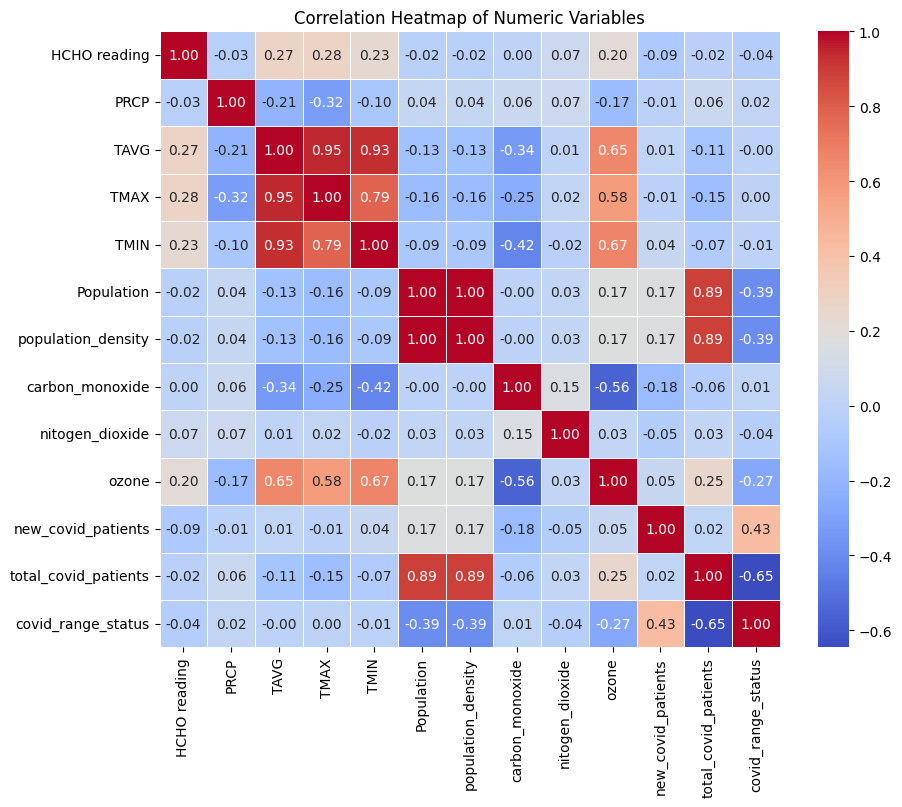

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

In [24]:
X = X[["Current Date", "ozone", "TMAX"]]
X.head() 

,Current Date,ozone,TMAX
0,2019-01-01,0.117317,79.556
1,2019-01-02,0.117317,79.790
2,2019-01-03,0.117317,80.312
3,2019-01-04,0.117317,80.312
4,2019-01-05,0.117317,80.510


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Current Date  1826 non-null   object 
 1   ozone         1826 non-null   float64
 2   TMAX          1826 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.9+ KB


#### Standardize, variable data

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Select columns of interest
selected_columns = ["ozone", "TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X['Year'] = X['Current Date'].dt.year
X['Month'] = X['Current Date'].dt.month
X['Day'] = X['Current Date'].dt.day

X.set_index("Current Date", inplace=True)

X.head()

,ozone,TMAX,Year,Month,Day
Current Date,,,,,
2019-01-01,0.501983,0.089744,2019,1,1
2019-01-02,0.501983,0.104895,2019,1,2
2019-01-03,0.501983,0.138695,2019,1,3
2019-01-04,0.501983,0.138695,2019,1,4
2019-01-05,0.501983,0.151515,2019,1,5


In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ozone   1826 non-null   float64
 1   TMAX    1826 non-null   float64
 2   Year    1826 non-null   int32  
 3   Month   1826 non-null   int32  
 4   Day     1826 non-null   int32  
dtypes: float64(2), int32(3)
memory usage: 64.2 KB


##### Standardize target variable

In [28]:
y = data['HCHO reading']

y.head()

0    0.000058
1    0.000102
2    0.000039
3   -0.000002
4    0.000159
Name: HCHO reading, dtype: float64

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [30]:
X_scaled = X

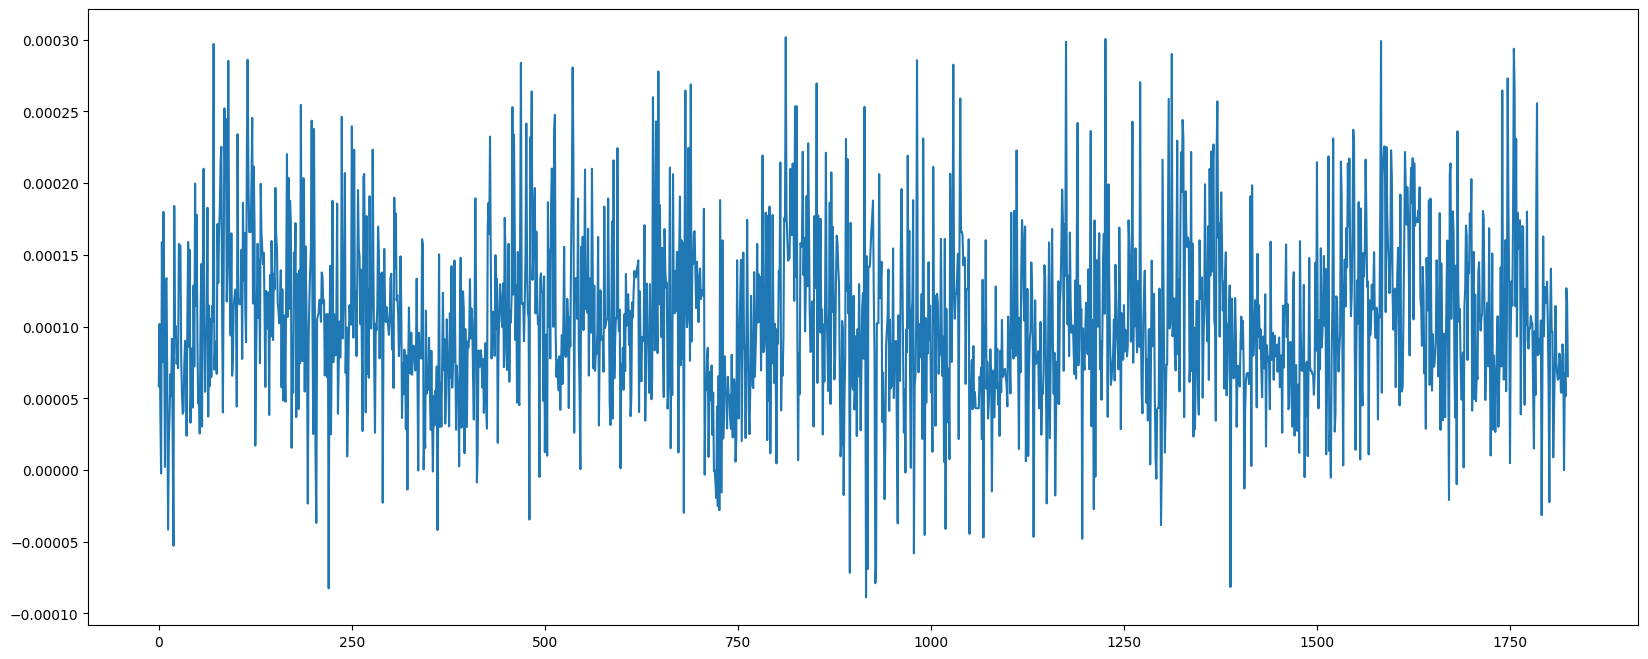

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [32]:
print(X_scaled.head())

                 ozone      TMAX  Year  Month  Day
Current Date                                      
2019-01-01    0.501983  0.089744  2019      1    1
2019-01-02    0.501983  0.104895  2019      1    2
2019-01-03    0.501983  0.138695  2019      1    3
2019-01-04    0.501983  0.138695  2019      1    4
2019-01-05    0.501983  0.151515  2019      1    5


In [33]:
y_scaled[:10]

array([[0.37662644],
       [0.4880266 ],
       [0.32796424],
       [0.22114673],
       [0.63434905],
       [0.42040063],
       [0.68817125],
       [0.4698685 ],
       [0.23265751],
       [0.56513873]])

#### Apply multivariate time series model

In [378]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]


model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True, activation="relu"), input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    Bidirectional(LSTM(units=5)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

# Compilation of the model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 11s 52ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 2/150
46/46 [==============================] - 1s 12ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 3/150
46/46 [==============================] - 1s 12ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 4/150
46/46 [==============================] - 1s 12ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 5/150
46/46 [==============================] - 1s 12ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 6/150
46/46 [==============================] - 1s 12ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 7/150
46/46 [========

46/46 [==============================] - 1s 13ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 102/150
46/46 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 103/150
46/46 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 104/150
46/46 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 105/150
46/46 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 106/150
46/46 [==============================] - 1s 13ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 107/150
46/46 [=========

In [379]:
model.predict(X_test)[:5]

12/12 [==============================] - 2s 5ms/step


array([[0.5037039],
       [0.5037039],
       [0.5037039],
       [0.5037039],
       [0.5037039]], dtype=float32)

In [380]:
y_test[:5]

array([[0.63006497],
       [0.46456218],
       [0.52372591],
       [0.33575319],
       [0.33852374]])

12/12 [==============================] - 0s 3ms/step


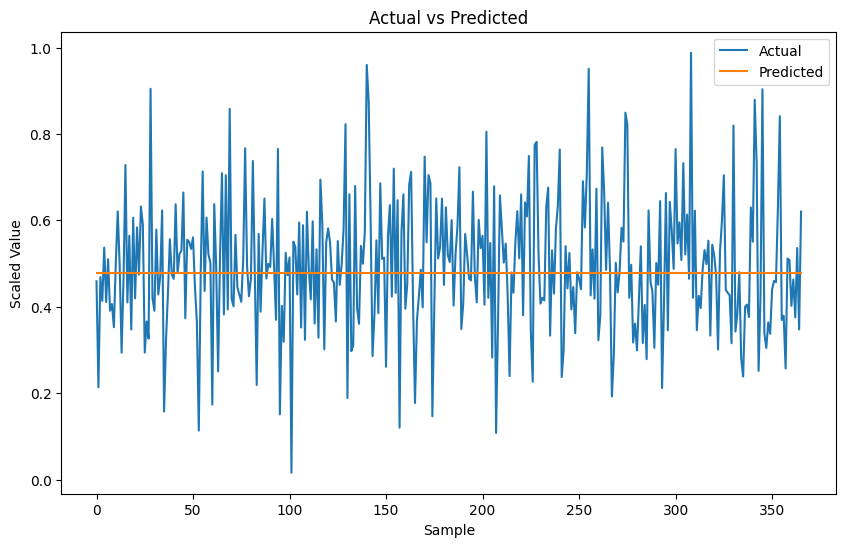

In [374]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

12/12 [==============================] - 0s 3ms/step - loss: 0.0246
Test Loss: 0.024568242952227592
12/12 [==============================] - 0s 3ms/step


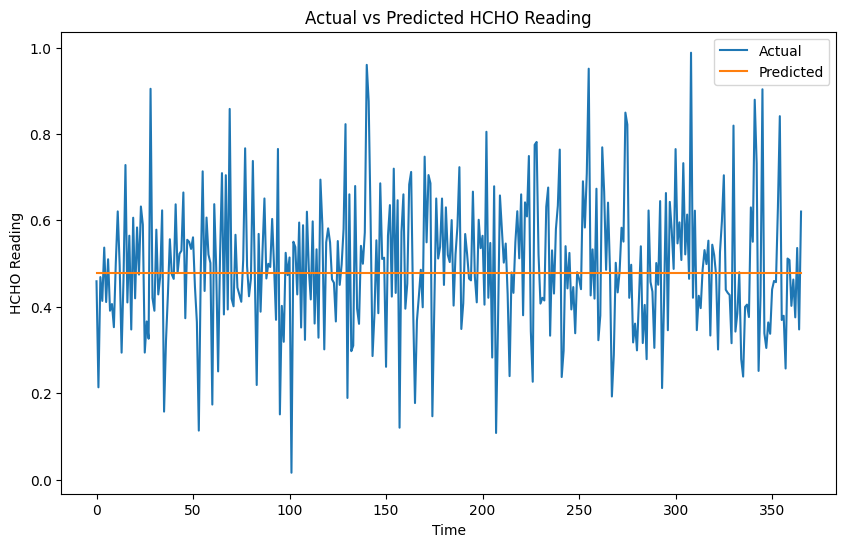

In [375]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = predictions
actual = y_test
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 2ms/step


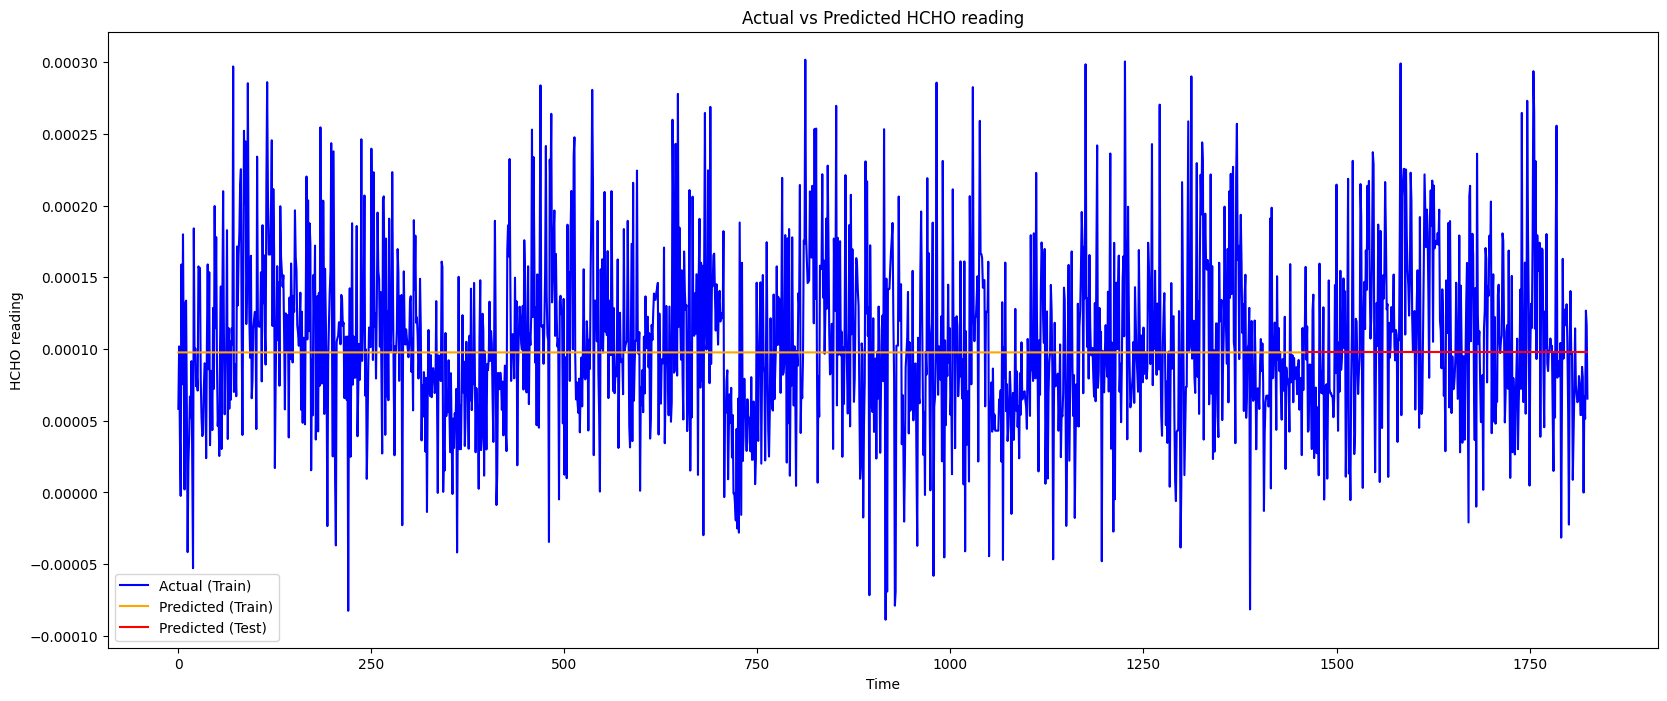

In [376]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [377]:
r2 = (r2_score(actual_test, predictions_test))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.013278074379671212
Mean Absolute Error (MAE): 4.7283804630226564e-05
Mean Squared Error (MSE): 3.743734232581701e-09
Root Mean Squared Error (RMSE): 6.118606240461713e-05
Median Absolute Error: 3.6438467865580174e-05
Explained Variance Score: 5.3260681420752576e-09


#### BayesianRidge Model

#### Single Variate models using Arema

#### Jaffna AR model

In [33]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(1, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [02:57<00:00,  2.06it/s]

ARIMA MSE: 3.2968350669235574e-09


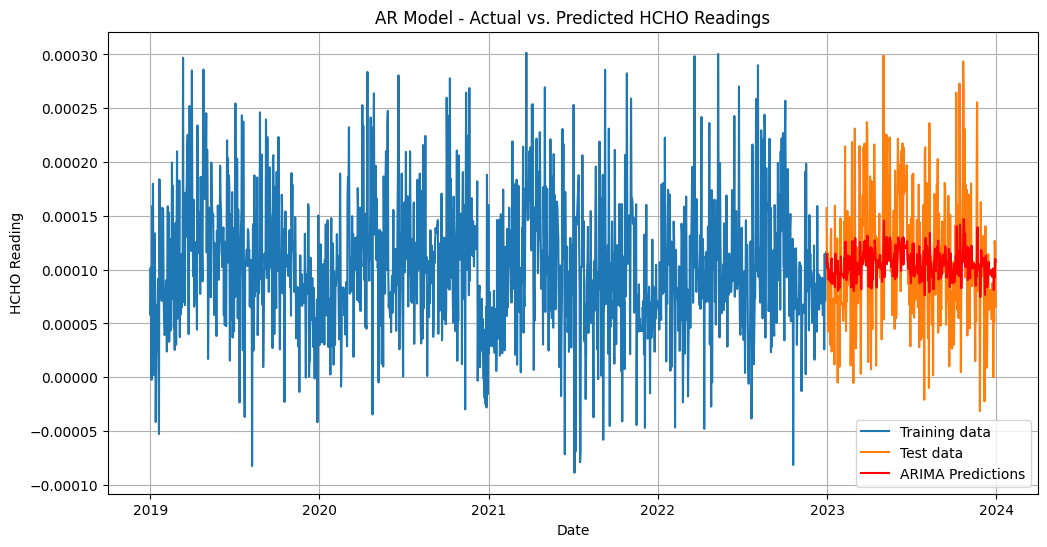

In [34]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

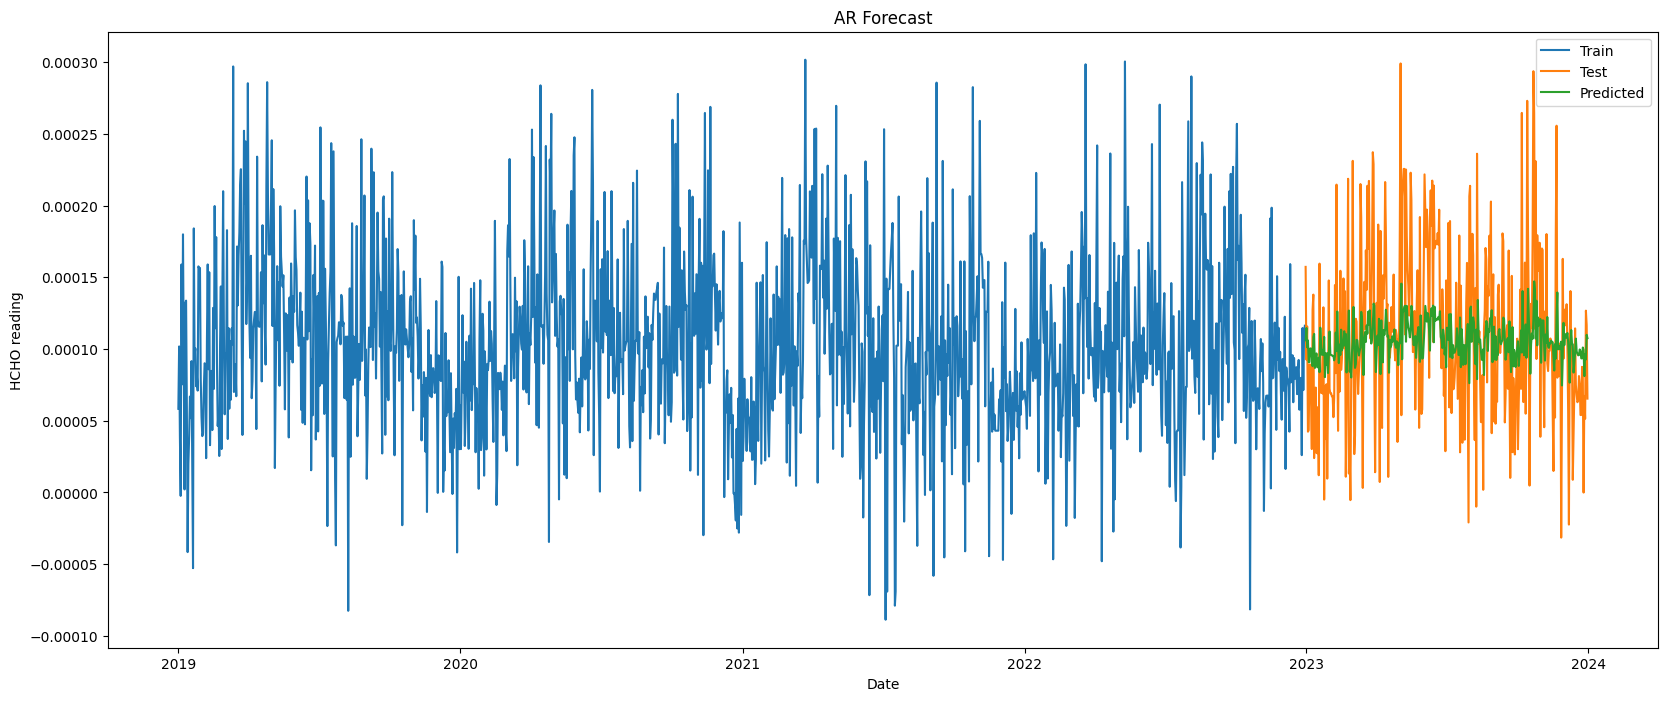

In [35]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['HCHO reading'], label='Train')
plt.plot(test.index, test['HCHO reading'], label='Test')
plt.plot(test.index, yhat_ar, label='Predicted')

plt.title('AR Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO reading')
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_ar)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_ar) 

rmse = mean_squared_error(test['HCHO reading'], yhat_ar, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_ar)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_ar) 


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.5278619718676945e-05
Mean Squared Error (MSE): 3.2968350669235574e-09
R-squared (R2) Score: 0.07286874013384703
Root Mean Squared Error (RMSE): 5.741807265072172e-05
Median Absolute Error: 3.9072839945780485e-05
Explained Variance Score: 0.0802209498473655


#### Arima model

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example using auto_arima
model = auto_arima(train['HCHO reading'], exogenous=train[['TMAX', 'ozone']],
                   seasonal=True, m=12,  # assuming monthly seasonality
                   trace=True)  # to display the model selection process
model_fit = model.fit(train['HCHO reading'], exogenous=train[['TMAX', 'ozone']])

# Forecasting
forecast = model_fit.predict(n_periods=len(test), exogenous=test[['TMAX', 'ozone']])

# Calculating MSE
sarima_mse = mean_squared_error(test['HCHO reading'], forecast)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-23906.166, Time=5.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24243.131, Time=0.25 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-23750.934, Time=1.92 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-24296.458, Time=5.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-22228.724, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-24271.807, Time=0.84 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-24159.081, Time=7.57 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-24298.384, Time=14.21 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=18.55 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-24274.038, Time=8.84 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-24329.351, Time=18.14 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-24327.023, Time=6.45 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=28.51 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-23650.887, Time=4.98 sec
 

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(5, 0, 0))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0] 
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [06:08<00:00,  1.01s/it]

ARIMA MSE: 3.1779576676667446e-09


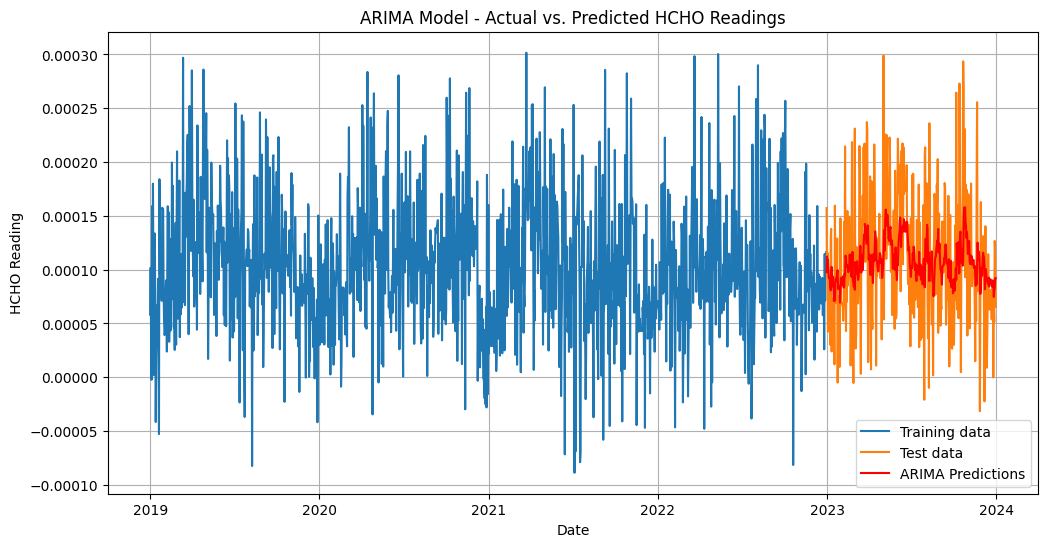

In [18]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

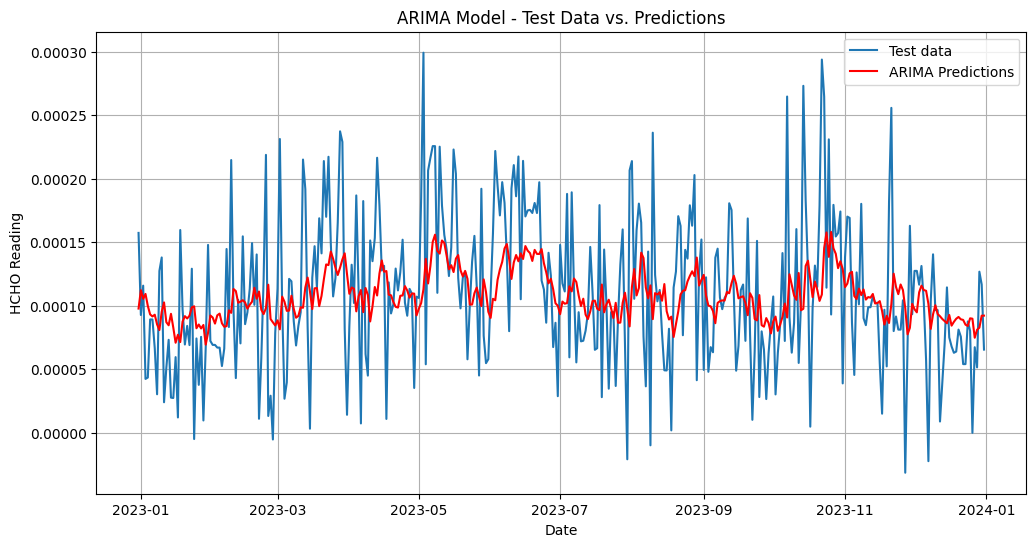

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.3354114627381614e-05
Mean Squared Error (MSE): 3.1779576676667446e-09
R-squared (R2) Score: 0.10629927296466524
Root Mean Squared Error (RMSE): 5.637337729519799e-05
Median Absolute Error: 3.4065344458121647e-05
Explained Variance Score: 0.10936402270597723


#### SARIMA model

In [381]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
   'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(5, 0, 0), seasonal_order=(0, 0, 0, 12))  # SARIMA model with p=1,d=0,q=1 and seasonal order (P,D,Q,s) = (1,0,1,12)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima) 

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [07:27<00:00,  1.22s/it]

SARIMA MSE: 3.430439364874286e-09


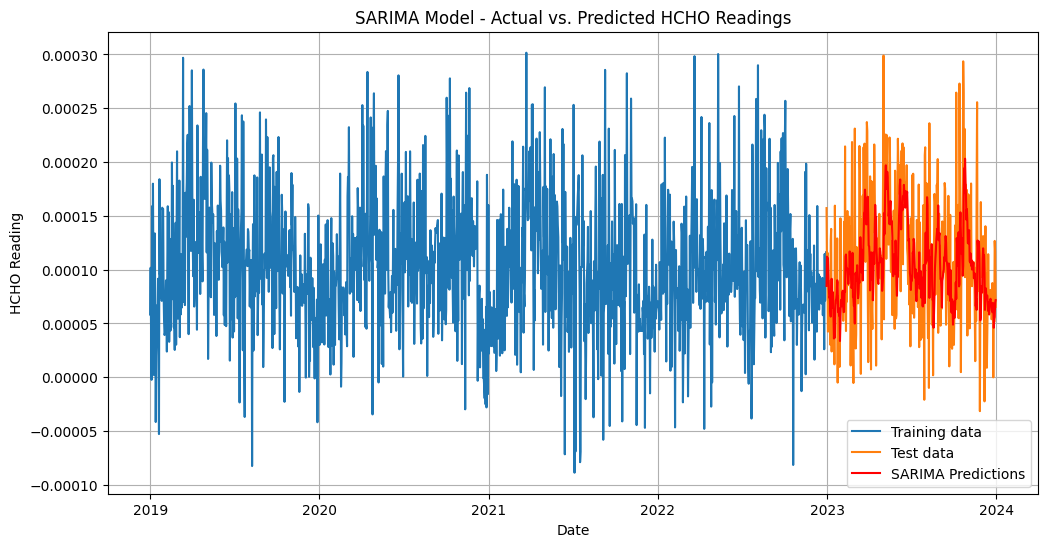

In [382]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

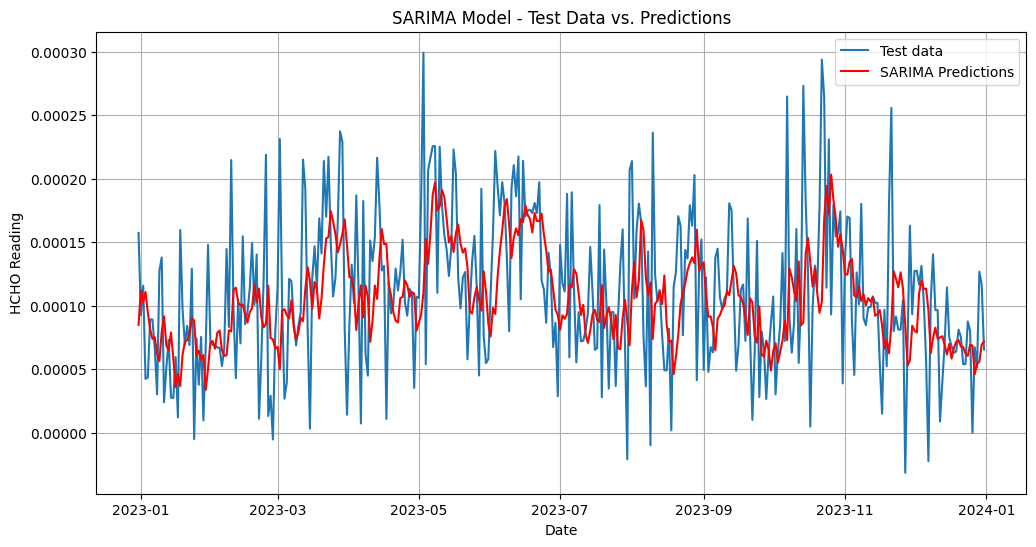

In [383]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [384]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 4.431961730010622e-05
Mean Squared Error (MSE): 3.430439364874286e-09
R-squared (R2) Score: 0.035296729836656215
Root Mean Squared Error (RMSE): 5.856995274775528e-05
Median Absolute Error: 3.442504507088432e-05
Explained Variance Score: 0.04412405825591803


Root Mean Squared Error: 6.0094513867808125e-05


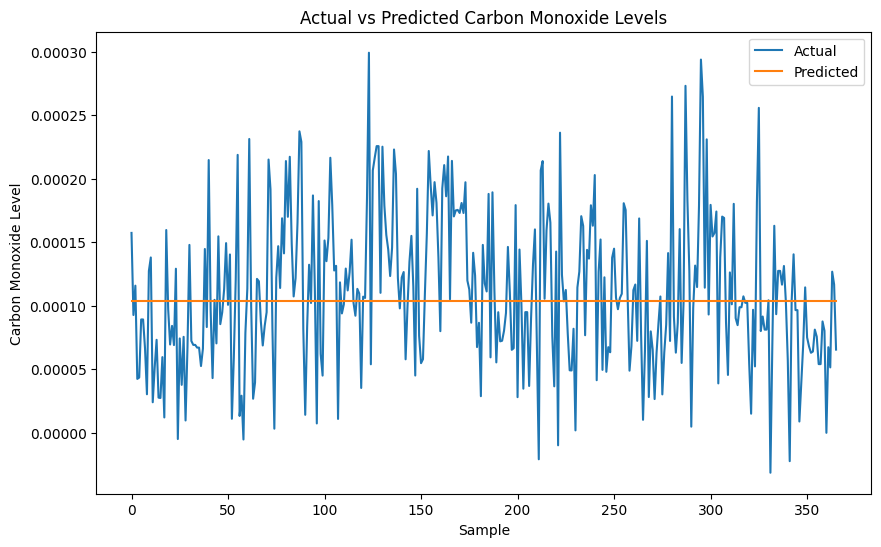

In [386]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX', 'carbon_monoxide', 'nitrogen_dioxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide', 'nitrogen_dioxide']].values
y_test = test['HCHO reading'].values

# Initialize the XGBoost regression model
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Carbon Monoxide Levels')
plt.xlabel('Sample')
plt.ylabel('Carbon Monoxide Level')
plt.legend()
plt.show()

Root Mean Squared Error: 5.8573155957323244e-05


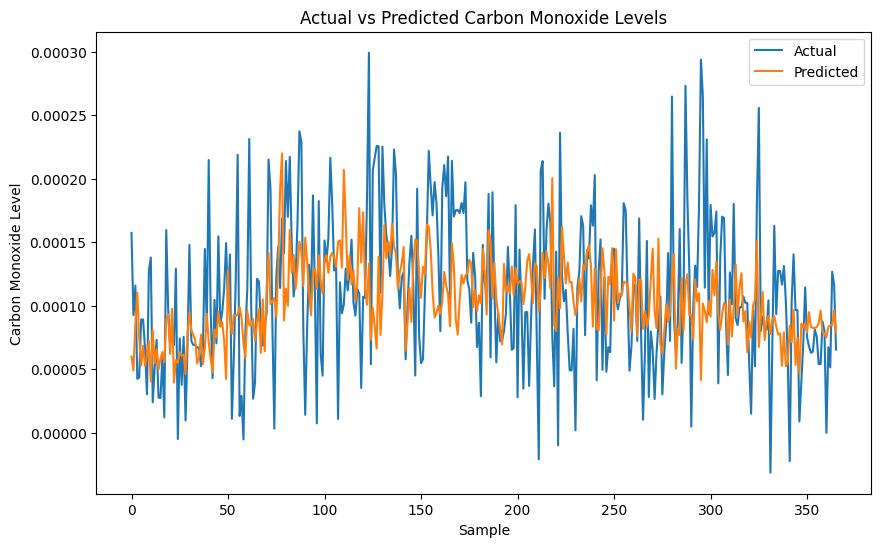

In [391]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv("../AnalysedFinalData/jaffnaData.csv", parse_dates=True)

# Drop the "Next Date" column
data.drop(columns=["Next Date"], inplace=True)

# Prepare the data
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'HCHO reading': data["HCHO reading"]
}

data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Extracting features and target variable
X_train = train[['TMAX', 'carbon_monoxide', 'nitrogen_dioxide']].values
y_train = train['HCHO reading'].values
X_test = test[['TMAX', 'carbon_monoxide', 'nitrogen_dioxide']].values
y_test = test['HCHO reading'].values

# Initialize the Random Forest Regression model with a large number of trees
model = RandomForestRegressor(n_estimators=100, n_jobs=10)

# Fit the model to the training data
model.fit(X_train, y_train) 

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Carbon Monoxide Levels')
plt.xlabel('Sample')
plt.ylabel('Carbon Monoxide Level')
plt.legend()
plt.show()